In [1]:
# import packages
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np

import swifter
import great_expectations as ge

In [2]:
# import datasets
train_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_in_encodedToNacSeq.csv', usecols=lambda x: x!= '*Unnamed*')
train_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_out.csv', usecols=lambda x: x!= '*Unnamed*')
test_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/test_in_encodedToNacSeq.csv', usecols=lambda x: x!= '*Unnamed*')
test_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/test_out.csv', usecols=lambda x: x!= '*Unnamed*')

# split to respective input datasets
train_X_nac = train_X.iloc[:, 0:4]
train_X_dac = train_X.iloc[:, 4:20]
train_X_tac = train_X.iloc[:, 20:]
test_X_nac = test_X.iloc[:, 0:4]
test_X_dac = test_X.iloc[:, 4:20]
test_X_tac = test_X.iloc[:, 20:]

# compressed output y
# transform target >=1 to 1
def normalize_output(x):
    return np.where(x.target>1, x.target/x.target, x.target)
    
# compressed y-variable
compressed_train_y = train_y.sum(axis=1).to_frame(name='target')
compressed_test_y = test_y.sum(axis=1).to_frame(name='target')
compressed_train_y.target = compressed_train_y.swifter.apply(normalize_output, axis=1)
compressed_test_y.target = compressed_test_y.swifter.apply(normalize_output, axis=1)

# Code below perform Feature Selection with Recursive Feature Elimination (RFE)

### start with 30 features selected via RFE

In [7]:
# Get an estimator object
rfc1 = RandomForestClassifier(n_estimators = 20)
rfe = RFE(estimator = rfc1, n_features_to_select = 30, step = 1)

# train RFE model
rfe.fit(train_X,compressed_train_y)

RFE(estimator=RandomForestClassifier(n_estimators=20), n_features_to_select=30)

In [8]:
# Create new Train and Test datasets
X_train_rfe = rfe.transform(train_X)
X_test_rfe = rfe.transform(test_X)

In [9]:
# Fit the Random Forest classifier to the new train and test with 80 features
# .values will give the values in a numpy array (shape: (n,1))
#.ravel will convert that array shape to (n, ) (i.e. flatten it)

rfc1.fit(X_train_rfe, compressed_train_y.values.ravel())

RandomForestClassifier(n_estimators=20)

In [10]:
import pickle
pickle.dump(rfc1, open('/Users/eesoonhang/Desktop/Jupyter Project/Capstone - RNAModX/predictive_model/RandomForrest_1.pkl','wb'))

In [11]:
# perform prediction
pred_y = rfc1.predict(X_test_rfe)

In [12]:
# evaluate performance
from sklearn import metrics 
print("Accuracy:",metrics.accuracy_score(compressed_test_y, pred_y)) 
print("Precision:",metrics.precision_score(compressed_test_y, pred_y)) 
print("Recall:",metrics.recall_score(compressed_test_y, pred_y))
print ("AUC:", metrics.roc_auc_score(y_true=compressed_test_y, y_score=pred_y))

# visualize confusion matrix
cnf_matrix = metrics.confusion_matrix(compressed_test_y, pred_y)
print("Confusion matrix:")
print(cnf_matrix)

Accuracy: 0.7508333333333334
Precision: 0.7617391304347826
Recall: 0.73
AUC: 0.7508333333333334
Confusion matrix:
[[463 137]
 [162 438]]


In [13]:
# Get the ranking of the features. Ranking 1 for selected features
ranking = rfe.ranking_
ranking

array([ 1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  9,  1,  2,  1,  1,  1,
        1,  1,  1,  1, 12,  1, 20, 33, 42,  3, 26, 23, 35,  1, 34,  1, 47,
       32,  1, 17, 25, 14, 24, 40, 11, 13, 38,  1, 49, 54, 55, 44,  1, 29,
        6,  1,  1,  1, 36, 46, 41, 53, 51,  7, 10,  4, 28, 48, 52, 19, 39,
       15, 50,  1, 31, 22, 43, 45, 21, 27, 37, 30, 18,  8,  1, 16,  1])

In [14]:
# Get the feature importance
importance = rfc1.feature_importances_
importance

array([0.03125324, 0.03492722, 0.02906496, 0.03450938, 0.03001988,
       0.02972007, 0.04157529, 0.0289764 , 0.04003057, 0.0528212 ,
       0.03230712, 0.03249678, 0.02976695, 0.03764347, 0.02852939,
       0.03063384, 0.03189013, 0.02959706, 0.03309485, 0.02892572,
       0.02942857, 0.04005861, 0.03810063, 0.02767237, 0.03797165,
       0.03116039, 0.02853849, 0.04092211, 0.02784661, 0.03051705])

In [18]:
# convert the ranking and importance into dataframe
rfe_selected = pd.DataFrame()
rfe_selected = pd.concat([pd.DataFrame(train_X.columns), 
                          pd.DataFrame(ranking),
                          pd.DataFrame(importance)], axis=1)
rfe_selected.columns = ['Feature Name', 'Ranking', 'Importance']
rfe_selected

,Feature Name,Ranking,Importance
0,A,1,0.031253
1,C,1,0.034927
2,G,1,0.029065
3,T,1,0.034509
4,AA,1,0.030020
...,...,...,...
79,TGT,18,NaN
80,TTA,8,NaN
81,TTC,1,NaN
82,TTG,16,NaN


In [19]:
# display RFE selected features (where ranking=1)   
rfe_selected[(rfe_selected.Ranking == 1)]['Feature Name']

0       A
1       C
2       G
3       T
4      AA
5      AC
7      AT
8      CA
9      CC
10     CG
12     GA
14     GG
15     GT
16     TA
17     TC
18     TG
19     TT
20    AAA
22    AAG
30    AGG
32    ATA
35    ATT
44    CGA
49    CTC
52    GAA
53    GAC
54    GAG
70    TAG
81    TTC
83    TTT
Name: Feature Name, dtype: object

# Code below find the optimum number of feature selection
### apply StandardScaler
### use wrapper method: RFE
### classifier with n_estimator=20
### selected n_features: based on 10, 20, 30, 40 and 50th percentile of total features

In [3]:
# import datasets
train_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_in_encodedToNacSeq.csv', usecols=lambda x: x!= '*Unnamed*')
train_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/train_out.csv', usecols=lambda x: x!= '*Unnamed*')
test_X = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/test_in_encodedToNacSeq.csv', usecols=lambda x: x!= '*Unnamed*')
test_y = pd.read_csv('/Users/eesoonhang/Desktop/capstone_data/test_out.csv', usecols=lambda x: x!= '*Unnamed*')

# compressed output y
# transform target >=1 to 1
def normalize_output(x):
    return np.where(x.target>1, x.target/x.target, x.target)
    
# compressed y-variable
compressed_train_y = train_y.sum(axis=1).to_frame(name='target')
compressed_test_y = test_y.sum(axis=1).to_frame(name='target')
compressed_train_y.target = compressed_train_y.swifter.apply(normalize_output, axis=1)
compressed_test_y.target = compressed_test_y.swifter.apply(normalize_output, axis=1)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math

def optimum_RFEModel(n_features):
    
    print('Number of features to be selected: ' , n_features)
    
    print('scaling data')
    scaler = StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X, compressed_train_y)
    train_X_scaled = pd.DataFrame(train_X_scaled, columns=train_X.columns)
    X_train, X_valid, Y_train, Y_valid = train_test_split(train_X_scaled, compressed_train_y, test_size = 0.5, random_state = 1234, stratify=compressed_train_y)
    X_train.shape
    
    print('selecting feature via RFE..')
    # instantiate model
    rfc = RandomForestClassifier(n_estimator=100)
    rfe = RFE(estimator = rfc, n_features_to_select = n_features, step = 1)
    # apply RFE
    rfe.fit(X_train, Y_train.values.ravel())
    # refactor train_X and test_X with rfe
    print('refactoring dataset...')
    rfe_train_X = rfe.transform(X_train)
    rfe_valid_X = rfe.transform(X_valid)
    
    print('fit model...')
    # Perform RandomForestClassification
    rfc.fit(rfe_train_X, Y_train.values.ravel())
    y_predict = rfc.predict(rfe_valid_X)
    
    print('evaluate model...')
    # print ranking based on rfe
    columns = X_train.columns
    ranking = rfe.ranking_
    rfe_selected = pd.concat([pd.DataFrame(columns), 
                              pd.DataFrame(ranking)], axis=1)
    rfe_selected.columns = ['Feature Name', 'Ranking']
    print('rankings: ' + str(ranking) + '\n' + 'RFE selected features: \n' + '-'*20 + '\n' + str(rfe_selected[(rfe_selected.Ranking == 1)]['Feature Name']))

    rmse = math.sqrt(mean_squared_error(Y_valid, y_predict))
    print('rmse: %4.2f' %rmse)
    
    score = rfc.score(rfe_valid_X, Y_valid)
    print('score: %4.2f' %score)
    
    return n_features, rmse, score, rfc, rfe, scaler

In [41]:
# define a list of feature number to be selected
n_features_list = list(map(lambda x : int(x * len(train_X.columns)), [0.1, 0.2, 0.3, 0.4, 0.5]))
n_features_list

[8, 16, 25, 33, 42]

In [44]:
%time results = list(map(optimum_RFEModel, n_features_list))

8
instantiating model...
modeling SFS...
refactoring dataset...
fit model...
evaluate model...
rankings: [ 1  1  1  1 18 10 31  4 15  1  1 29  6 21  3 16  1 12  7  1  9 30 11 45
 55 61 42 51 47 58 23 56 25 70 53 13 37 50 39 52 57 33 60 54 17 75 38 76
 67 27 48 32  2 22 14 62 66 64 77 69 28 26 24 44 73 74 41 63 40 72  5 36
 46 68 71 35 49 65 59 34 19 20 43  8]
RFE selected features: 
--------------------
0      A
1      C
2      G
3      T
9     CC
10    CG
16    TA
19    TT
Name: Feature Name, dtype: object
rmse: 0.53
score: 0.72
16
instantiating model...
modeling SFS...
refactoring dataset...
fit model...
evaluate model...
rankings: [ 1  1  1  1 11  2 19  5 10  1  1 20  1 13  1  9  1  6  1  1  1 24  1 27
 44 52 36 42 38 57 14 43 16 62 50  1 29 39 28 47 45 26 51 53  3 67 25 68
 54 15 46 21  1 12  8 49 55 56 69 61 23 22 17 32 66 65 40 60 34 64  1 33
 37 58 63 31 41 59 48 30  4 18 35  7]
RFE selected features: 
--------------------
0       A
1       C
2       G
3       T
9      CC
10    

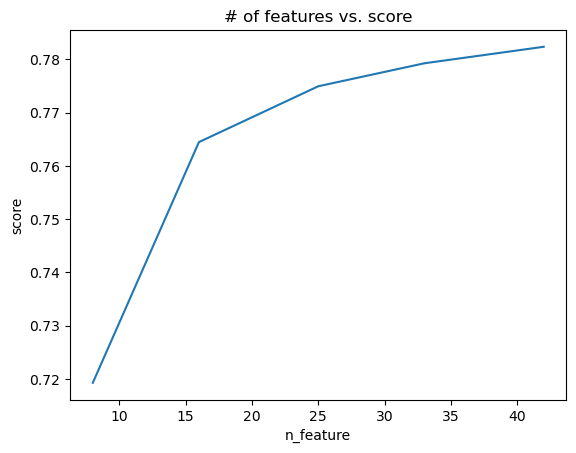

In [45]:
scores = [r[1] for r in results]

import matplotlib.pyplot as plt
plt.plot(n_features_list, scores)
plt.xlabel('n_feature')
plt.ylabel('score')
plt.title('# of features vs. score')
plt.show()

In [ ]:
# Conclusion
# The best performance obtained with rfc via rfe-treated is 0.78 accuracy (around 40th-percentile of total features)

### change n_estimators for classifier to 100 (default)
### set n_features to 33 for RFE

In [15]:
# export the yet-the-best model
%time model = optimum_RFEModel(33)

Number of features to be selected:  33
instantiating model...
modeling RFE...
refactoring dataset...
fit model...
evaluate model...
rankings: [ 1  1  1  1  1  1  6  1  1  1  1 12  1  1  1  1  1  1  1  1  1  9  1 18
 26 42 11 28 23 39  1 32  1 46 29  1 16 27 15 25 35 13  1 31  1 43  1 51
 37  3 33  5  1  1  1 34 44 36 52 47  8  4  2 17 49 50 21 40 10 48  1  7
 22 38 45 20 24 41 30 14  1  1 19  1]
RFE selected features: 
--------------------
0       A
1       C
2       G
3       T
4      AA
5      AC
7      AT
8      CA
9      CC
10     CG
12     GA
13     GC
14     GG
15     GT
16     TA
17     TC
18     TG
19     TT
20    AAA
22    AAG
30    AGG
32    ATA
35    ATT
42    CCG
44    CGA
46    CGG
52    GAA
53    GAC
54    GAG
70    TAG
80    TTA
81    TTC
83    TTT
Name: Feature Name, dtype: object
rmse: 0.45
score: 0.80
CPU times: user 49min 30s, sys: 15.8 s, total: 49min 45s
Wall time: 49min 53s


In [16]:
# export the model
import pickle 
pickle.dump(model[3], open('/Users/eesoonhang/Desktop/capstone_data/RFC_100trees_withRFE.pkl', 'wb'))
pickle.dump(model[4], open('/Users/eesoonhang/Desktop/capstone_data/RFE_33.pkl', 'wb'))

In [ ]:
clf = pickle.load(open('/Users/eesoonhang/Desktop/capstone_data/RFC_100trees_withRFE.pkl', 'rb'))

In [17]:
test_X_scaled = scaler.transform(test_X)
rfe_test_X = rfe.transform(test_X)
clf.score(rfe_test_X, compressed_test_y)

0.4925

Text(0.5, 427.9555555555555, 'Predicted label')

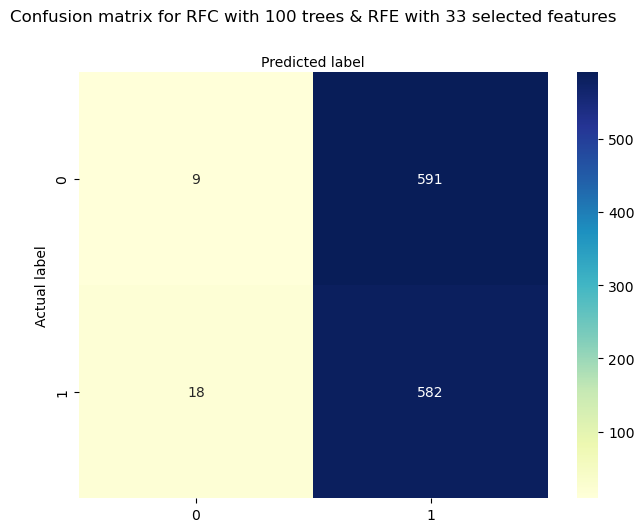

In [18]:
from sklearn.metrics import confusion_matrix as cfm
import matplotlib.pyplot as plt
import seaborn as sns
# visualize confusion matrix
cnf_matrix = cfm(compressed_test_y, clf.predict(rfe_test_X)) 
class_names=[0,1] # name  of classes
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix for RFC with 100 trees & RFE with 33 selected features', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

In [ ]:
# findings:
# 1. standardscaler cause overfitting issue for RF with 100 trees

# Code below utilizes PCA for dimension reduction

### with Scaler

In [22]:
from sklearn.decomposition import PCA

# perform standard scaler on the train dataset
train_X_scaled = scaler.fit_transform(train_X)
train_X_scaled = pd.DataFrame(train_X_scaled, columns=train_X.columns)
train_X_scaled

,A,C,G,T,AA,AC,AG,AT,CA,CC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,-0.704832,2.535937,1.381363,-1.115445,-1.104123,1.334939,-0.183665,-1.031212,0.387561,2.948961,...,3.269110,-0.764550,-0.895533,0.451668,-0.078219,-1.557006,-1.459063,-0.713885,-1.014606,-1.432964
1,0.314292,0.450969,0.428561,0.793384,-0.007430,0.508467,0.077631,0.531757,0.614703,0.306727,...,0.028678,0.553666,1.331778,0.281961,1.848610,-0.675370,0.897247,0.296124,0.259780,0.607649
2,0.518117,0.727993,0.264798,0.486857,0.288974,1.034404,0.652482,-0.002943,1.807197,0.016725,...,-0.619408,1.344595,1.172684,2.318447,-0.463585,-0.171578,0.040407,1.017558,0.118182,-0.229525
3,0.954884,0.057304,0.517886,0.472924,1.267106,0.358199,1.018297,-0.044073,0.671488,-0.144386,...,0.352722,0.158201,0.854497,0.281961,0.307146,0.584111,0.683037,-0.136737,-0.023417,0.293709
4,1.289739,-0.788347,0.205247,1.253175,1.474589,-0.468273,0.443445,1.518896,-0.748147,-0.756611,...,-0.295365,-0.105442,0.536310,0.451668,0.692512,0.458163,1.325667,0.440411,1.250970,1.183207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304656,-0.719391,-1.298654,-1.402607,-0.418792,-0.303833,-0.994210,-1.385627,-0.002943,-1.259216,-0.982168,...,-0.295365,-1.028193,-0.577346,-1.754525,-0.592040,-0.675370,0.254617,-0.136737,0.118182,0.241385
304657,-0.966892,-0.904989,-0.970868,-0.962182,-0.659518,-1.069343,-0.863035,-0.578774,-1.316001,-0.466610,...,-0.619408,-1.028193,-0.259158,-0.566575,-0.848951,-0.549422,-0.923538,0.007550,-0.448212,-0.805083
304658,-1.287189,-0.234300,-0.881543,-1.380173,-0.867000,-0.393139,-1.228850,-1.277997,-0.407435,0.145615,...,-0.619408,-0.500907,-1.372814,-0.566575,-0.463585,-0.549422,-1.137748,-0.425311,-1.014606,-1.014376
304659,-1.359983,-0.875828,-1.402607,-0.223729,-1.044842,-1.069343,-1.594664,-0.578774,-1.486358,-0.531055,...,0.028678,0.290022,-1.691001,-1.075696,-1.105861,-0.675370,0.575932,-0.136737,-0.873008,1.497147


In [26]:
# maintain 95% of information
pca = PCA(0.95)
pca_train_X = pca.fit_transform(train_X_scaled)

# check information importance per feature
pca.explained_variance_ratio_

array([0.31204928, 0.23052962, 0.07677082, 0.05282266, 0.0510569 ,
       0.02337444, 0.01693275, 0.01476762, 0.014247  , 0.01353255,
       0.01235725, 0.01143845, 0.01072787, 0.00922825, 0.00760299,
       0.00733781, 0.00704595, 0.00652927, 0.00608968, 0.00593093,
       0.00569174, 0.00562135, 0.00538682, 0.00522884, 0.00494306,
       0.00488103, 0.00482638, 0.0047584 , 0.00453404, 0.00435491,
       0.0042997 , 0.00424184, 0.0041226 ])

In [27]:
# use stratified method to split the dataset for initial model training
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(pca_train_X, compressed_train_y, test_size = 0.5, random_state = 1234, stratify=compressed_train_y)
X_train.shape

(152330, 33)

In [67]:
def optimum_PCAModel(percentile):
    
    print('% of retained information: ' , percentile*100)
    
    print('reducing dimension...')
    # maintain a specific percentile of information
    pca = PCA(percentile, random_state=123)
    pca_train_X = pca.fit_transform(train_X_scaled)
    
    # split the dataset
    X_train, X_valid, Y_train, Y_valid = train_test_split(pca_train_X, compressed_train_y, test_size = 0.5, random_state = 1234, stratify=compressed_train_y)
    
    print('fit model...')
    # Perform RandomForestClassification
    rfc = RandomForestClassifier()
    rfc.fit(X_train, Y_train.values.ravel())
    y_predict = rfc.predict(X_valid)
    
    print('evaluate model...')
    # evaluate model
    rmse = math.sqrt(mean_squared_error(Y_valid, y_predict))
    print('rmse: %4.2f' %rmse)
    
    score = rfc.score(X_valid, Y_valid)
    print('score: %4.2f' %score)
    
    return rmse, score, rfc, pca

In [68]:
# train model
%time model = optimum_PCAModel(0.95)

% of retained information:  95.0
reducing dimension...
fit model...
evaluate model...
rmse: 0.45
score: 0.80
CPU times: user 1min 53s, sys: 1.05 s, total: 1min 54s
Wall time: 1min 53s


In [72]:
# export the model
import pickle 
pickle.dump(model[2], open('/Users/eesoonhang/Desktop/capstone_data/RFC_100trees_withPCA.pkl', 'wb'))

In [70]:
# evaluate the model accuracy
clf = model[2]
pca = model[3]
test_X_scaled = scaler.transform(test_X)
pca_test_X = pca.transform(test_X_scaled)
clf.score(pca_test_X, compressed_test_y)

0.7208333333333333

Text(0.5, 427.9555555555555, 'Predicted label')

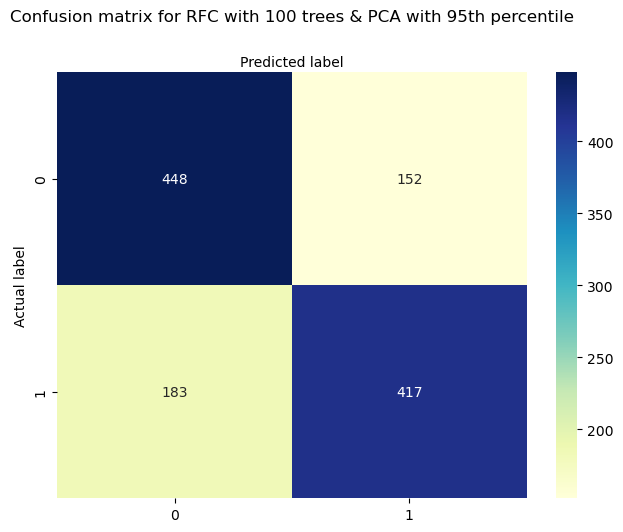

In [71]:
# visualize confusion matrix
cnf_matrix = cfm(compressed_test_y, clf.predict(pca_test_X)) 
class_names=[0,1] # name  of classes
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix for RFC with 100 trees & PCA with 95th percentile', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

### without a Scaler

In [73]:
# maintain 95% of information
pca = PCA(0.95)
pca_train_X_noScaler = pca.fit_transform(train_X)

# check information importance per feature
pca.explained_variance_ratio_

array([0.39822741, 0.37955737, 0.09939929, 0.04513144, 0.01844422,
       0.00863452, 0.00649779])

In [ ]:
# use stratified method to split the dataset for initial model training
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(pca_train_X_noScaler, compressed_train_y, test_size = 0.5, random_state = 1234, stratify=compressed_train_y)
X_train.shape

In [74]:
def optimum_PCAModel(percentile):
    
    print('% of retained information: ' , percentile*100)
    
    print('reducing dimension...')
    # maintain a specific percentile of information
    pca = PCA(percentile, random_state=123)
    pca_train_X = pca.fit_transform(train_X)
    
    # split the dataset
    X_train, X_valid, Y_train, Y_valid = train_test_split(pca_train_X, compressed_train_y, test_size = 0.5, random_state = 1234, stratify=compressed_train_y)
    
    print('fit model...')
    # Perform RandomForestClassification
    rfc = RandomForestClassifier()
    rfc.fit(X_train, Y_train.values.ravel())
    y_predict = rfc.predict(X_valid)
    
    print('evaluate model...')
    # evaluate model
    rmse = math.sqrt(mean_squared_error(Y_valid, y_predict))
    print('rmse: %4.2f' %rmse)
    
    score = rfc.score(X_valid, Y_valid)
    print('score: %4.2f' %score)
    
    return rmse, score, rfc, pca

In [75]:
# train model
%time model = optimum_PCAModel(0.95)

% of retained information:  95.0
reducing dimension...
fit model...
evaluate model...
rmse: 0.53
score: 0.72
CPU times: user 58.3 s, sys: 748 ms, total: 59 s
Wall time: 57.9 s


In [76]:
# evaluate the model accuracy
clf = model[2]
pca = model[3]
pca_test_X = pca.transform(test_X)
clf.score(pca_test_X, compressed_test_y)

0.6833333333333333

Text(0.5, 427.9555555555555, 'Predicted label')

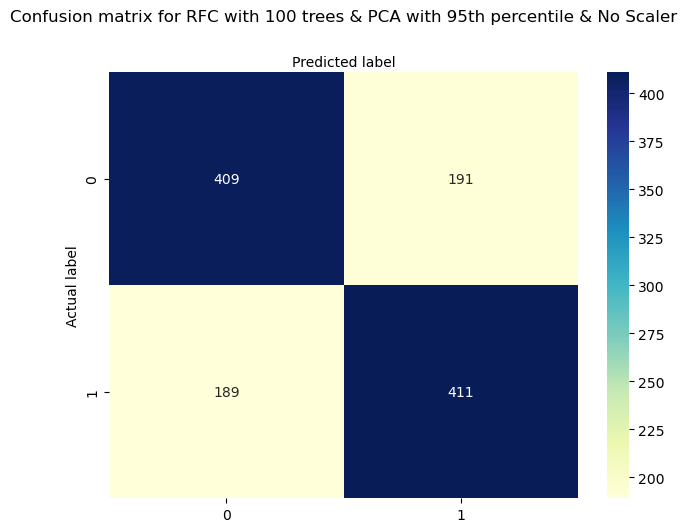

In [77]:
# visualize confusion matrix
cnf_matrix = cfm(compressed_test_y, clf.predict(pca_test_X)) 
class_names=[0,1] # name  of classes
fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names) 

# create heatmap 
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('Confusion matrix for RFC with 100 trees & PCA with 95th percentile & No Scaler', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

In [ ]:
# PCA with scaler perform better